In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD

import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
class oneNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Layer 1 (3 ReLU neurons)
        self.w00 = nn.Parameter(torch.tensor(1.10, dtype=torch.float32), requires_grad=True)
        self.b00 = nn.Parameter(torch.tensor(-0.50, dtype=torch.float32), requires_grad=True)

        self.w01 = nn.Parameter(torch.tensor(0.60, dtype=torch.float32), requires_grad=True)
        self.b01 = nn.Parameter(torch.tensor(-1.50, dtype=torch.float32), requires_grad=True)

        self.w02 = nn.Parameter(torch.tensor(0.50, dtype=torch.float32), requires_grad=True)
        self.b02 = nn.Parameter(torch.tensor(0.65, dtype=torch.float32), requires_grad=True)

        # Layer 2 (2 Sigmoid neurons)
        self.w10 = nn.Parameter(torch.tensor(0.90, dtype=torch.float32), requires_grad=True)
        self.b10 = nn.Parameter(torch.tensor(0.20, dtype=torch.float32), requires_grad=True)

        self.w11 = nn.Parameter(torch.tensor(-0.70, dtype=torch.float32), requires_grad=True)
        self.b11 = nn.Parameter(torch.tensor(0.40, dtype=torch.float32), requires_grad=True)

        # Output layer (linear)
        self.w20 = nn.Parameter(torch.tensor(1.60, dtype=torch.float32), requires_grad=True)
        self.b20 = nn.Parameter(torch.tensor(0.10, dtype=torch.float32), requires_grad=True)

    def forward(self, x, verbose=False):
        # Layer 1: ReLU
        z00 = x * self.w00 + self.b00
        a00 = F.relu(z00)

        z01 = x * self.w01 + self.b01
        a01 = F.relu(z01)

        z02 = x * self.w02 + self.b02
        a02 = F.relu(z02)

        L1 = a00 + a01 + a02  # sum of ReLU neurons

        # Layer 2: Sigmoid
        z10 = x * self.w10 + self.b10
        a10 = torch.sigmoid(z10)

        z11 = x * self.w11 + self.b11
        a11 = torch.sigmoid(z11)

        # sum of Sigmoid neurons
        L2 = a10 + a11

        # Combine + Tanh
        c_in = L1 + L2
        c = torch.tanh(c_in)

        # Output (linear)
        y = self.w20 * c + self.b20

        if verbose:
            def _p(name, t):
                try: print(name, ":", float(t))
                except: print(name, ":", t.detach().cpu().numpy())
            print("\n=== TRACE ===")
            _p("x", x)
            _p("z00", z00); _p("a00=ReLU(z00)", a00)
            _p("z01", z01); _p("a01=ReLU(z01)", a01)
            _p("z02", z02); _p("a02=ReLU(z02)", a02)
            _p("L1=sum(ReLU)", L1)

            _p("z10", z10); _p("a10=sigmoid(z10)", a10)
            _p("z11", z11); _p("a11=sigmoid(z11)", a11)
            _p("L2=sum(sigmoid)", L2)

            _p("c_in=L1+L2", c_in)
            _p("c=tanh(c_in)", c)
            _p("y=w20*c+b20", y)
        return y

    # help to print intermediates ad return y for scalar x
    def trace(self, x_scalar):
        y = self.forward(x_scalar, verbose=True)
        return y


In [29]:
class twoNN(nn.Module):
    def __init__(self):
        super().__init__()
        # start from inits
        self.w00 = nn.Parameter(torch.tensor(0.00)); self.b00 = nn.Parameter(torch.tensor(0.00))
        self.w01 = nn.Parameter(torch.tensor(0.00)); self.b01 = nn.Parameter(torch.tensor(0.00))
        self.w02 = nn.Parameter(torch.tensor(0.00)); self.b02 = nn.Parameter(torch.tensor(0.00))

        self.w10 = nn.Parameter(torch.tensor(0.00)); self.b10 = nn.Parameter(torch.tensor(0.00))
        self.w11 = nn.Parameter(torch.tensor(0.00)); self.b11 = nn.Parameter(torch.tensor(0.00))

        self.w20 = nn.Parameter(torch.tensor(0.00)); self.b20 = nn.Parameter(torch.tensor(0.00))

    def forward(self, x):
        # Layer 1
        a00 = F.relu(x * self.w00 + self.b00)
        a01 = F.relu(x * self.w01 + self.b01)
        a02 = F.relu(x * self.w02 + self.b02)
        L1 = a00 + a01 + a02

        # Layer 2
        a10 = torch.sigmoid(x * self.w10 + self.b10)
        a11 = torch.sigmoid(x * self.w11 + self.b11)
        L2 = a10 + a11

        # Combine + Tanh
        c = torch.tanh(L1 + L2)

        # Output
        y = self.w20 * c + self.b20
        return y



In [30]:
first_model = oneNN()

true_inputs = torch.linspace(start=1.0, end=2.5, steps=40)


In [31]:
with torch.no_grad():
    true_outputs = first_model(true_inputs)

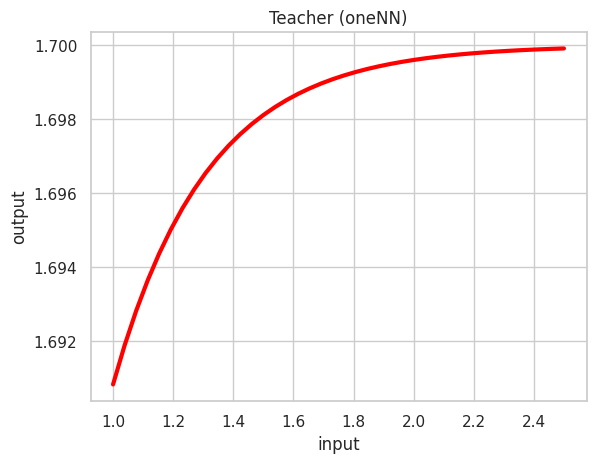

In [32]:
sns.set(style="whitegrid")
sns.lineplot(x=true_inputs, y=true_outputs, color='red', linewidth=3)
plt.title("Teacher (oneNN)")
plt.ylabel('output'); plt.xlabel('input')
plt.show()

In [33]:
x_scalar = torch.tensor(1.75, requires_grad=True)
# prints all intermediates
y_scalar = first_model.trace(x_scalar)
y_scalar.backward()
print("Gradient dy/dx at x=1.75:", x_scalar.grad.item())


=== TRACE ===
x : 1.75
z00 : 1.4250000715255737
a00=ReLU(z00) : 1.4250000715255737
z01 : -0.44999992847442627
a01=ReLU(z01) : 0.0
z02 : 1.524999976158142
a02=ReLU(z02) : 1.524999976158142
L1=sum(ReLU) : 2.950000047683716
z10 : 1.774999976158142
a10=sigmoid(z10) : 0.855078399181366
z11 : -0.8250000476837158
a11=sigmoid(z11) : 0.30470332503318787
L2=sum(sigmoid) : 1.1597816944122314
c_in=L1+L2 : 4.109781742095947
c=tanh(c_in) : 0.9994614720344543
y=w20*c+b20 : 1.6991384029388428
Gradient dy/dx at x=1.75: 0.002693165559321642


In [34]:
plain_first_nn = twoNN()
pred_outputs = plain_first_nn(true_inputs)

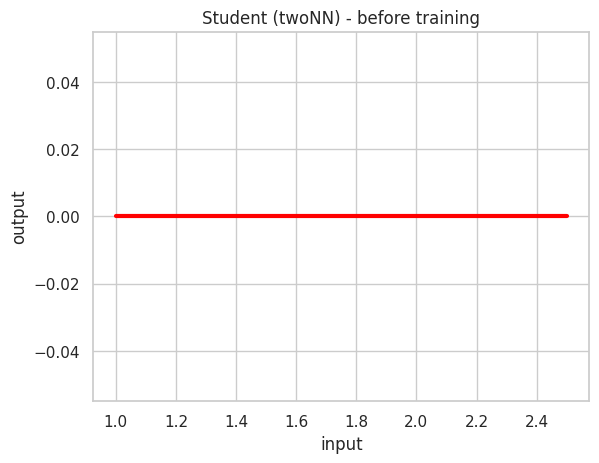

In [35]:
sns.lineplot(x=true_inputs, y=pred_outputs.detach(), color='red', linewidth=3)
plt.title("Student (twoNN) - before training")
plt.ylabel('output'); plt.xlabel('input')
plt.show()


In [36]:
optimizer = SGD(plain_first_nn.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

In [37]:
for epoch in range(200):
    total_loss = 0.0
    for i in range(len(true_inputs)):
        input_i = true_inputs[i]
        target_i = true_outputs[i]

        pred_i = plain_first_nn(input_i)
        loss_val = loss_fn(pred_i, target_i)

        loss_val.backward()
        total_loss += float(loss_val.detach())

    if epoch % 20 == 0:
        print("Epoch {epoch:03d} | Total Loss: {total_loss:.6f}")

    optimizer.step()
    optimizer.zero_grad()

Epoch {epoch:03d} | Total Loss: {total_loss:.6f}
Epoch {epoch:03d} | Total Loss: {total_loss:.6f}
Epoch {epoch:03d} | Total Loss: {total_loss:.6f}
Epoch {epoch:03d} | Total Loss: {total_loss:.6f}
Epoch {epoch:03d} | Total Loss: {total_loss:.6f}
Epoch {epoch:03d} | Total Loss: {total_loss:.6f}
Epoch {epoch:03d} | Total Loss: {total_loss:.6f}
Epoch {epoch:03d} | Total Loss: {total_loss:.6f}
Epoch {epoch:03d} | Total Loss: {total_loss:.6f}
Epoch {epoch:03d} | Total Loss: {total_loss:.6f}


In [38]:
# show a few learned params
print("Learned params (twoNN):")
print("w00 =", float(plain_first_nn.w00.detach()))
print("w01 =", float(plain_first_nn.w01.detach()))
print("w02 =", float(plain_first_nn.w02.detach()))
print("w10 =", float(plain_first_nn.w10.detach()))
print("w11 =", float(plain_first_nn.w11.detach()))
print("w20 =", float(plain_first_nn.w20.detach()))
print("b20 =", float(plain_first_nn.b20.detach()))


Learned params (twoNN):
w00 = 0.0
w01 = 0.0
w02 = 0.0
w10 = -0.020868312567472458
w11 = -0.020868312567472458
w20 = 0.8201832175254822
b20 = 1.0852677822113037


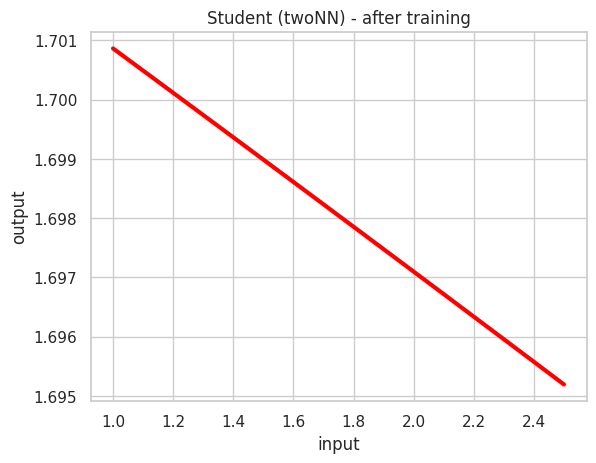

In [39]:
# after-training curve
pred_outputs = plain_first_nn(true_inputs)
sns.lineplot(x=true_inputs, y=pred_outputs.detach(), color='red', linewidth=3)
plt.title("Student (twoNN) - after training")
plt.ylabel('output'); plt.xlabel('input')
plt.show()